# NeuMiss + DeepSurv

In this notebook, we connect the NeuMiss component to a simple MLP.
NeuMiss directly handles NaN in the input vector.

TODOs:

- use stratified train/test split to avoid unknown values at test stage

In [32]:
from pathlib import Path

In [34]:
Path("a") / "b"

PosixPath('a/b')

In [25]:
import numpy as np
import pandas as pd # for data collection
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn_pandas import DataFrameMapper

import torch # For building the networks 
from torch import nn
import torch.nn.functional as F
import torchtuples as tt # Some useful functions

from pycox.datasets import rotterdam, gbsg
from pycox.models import CoxPH, DeepHitSingle
from pycox.preprocessing.label_transforms import LabTransDiscreteTime
# from pycox.models.loss import NLLLogistiHazardLoss
from pycox.evaluation import EvalSurv

In [26]:
np.random.seed(1234)
_ = torch.manual_seed(123)

# Methods

In [27]:
def surv_metrics(ev: EvalSurv, plot: bool = False):
    metrics = {}
    metrics['Ctd'] = ev.concordance_td('antolini')
    time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
    if plot:
        ev.brier_score(time_grid).plot()
        plt.ylabel('Brier score')
        _ = plt.xlabel('Time')
    metrics['iBS'] = ev.integrated_brier_score(time_grid)
    metrics['iNBLL'] = ev.integrated_nbll(time_grid)
    return(metrics)


def find_best_lr(model, train_set, batch_size=256, plot=False):
    lrfinder = model.lr_finder(train_set['X'], train_set['y'], batch_size, tolerance=10)
    if plot:
        lrfinder.plot()
        plt.title(f"Found best LR: {lrfinder.get_best_lr():.3f}")
    return lrfinder


# Preliminaries

## Dataset

In [28]:
df_train = rotterdam.read_df()
df_train['size'] = df_train['size'].astype('category')
df_train['rtime'] = df_train['rtime'].astype('int64')


def size_category(x):
    if x <= 20:
        return '<=20'
    elif x <= 50:
        return '20-50'
    elif x > 50:
        return '>50'
    else:
        raise

df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

df_test = gbsg.read_df()
df_test['size'] = df_test['size'].apply(size_category).astype('category')

# Continuous labels
get_target = lambda df, dataset: (df[dataset.col_duration].values, df[dataset.col_event].values)
y_train = get_target(df_train, rotterdam)
y_val = get_target(df_val, rotterdam)
y_test = get_target(df_test, gbsg)
# Discrete labels
labtrans = LabTransDiscreteTime(30)
y_train_discrete = labtrans.fit_transform(*y_train)
y_val_discrete = labtrans.fit_transform(*y_val)

assert(df_train.shape[0] == y_train[0].shape[0])


In [31]:
y_train

(array([1798, 2828, 6011, ...,   45, 4972,  378]),
 array([0, 0, 0, ..., 0, 0, 1]))

In [13]:
df_train

,age,meno,size,grade,nodes,pgr,er,hormon,rtime,recur
0,74,1,<=20,3,0,35,291,0,1798,0
1,79,1,20-50,3,0,36,611,0,2828,0
2,44,0,<=20,2,0,138,0,0,6011,0
3,70,1,20-50,3,0,0,12,0,2623,0
4,75,1,<=20,3,0,260,409,0,4914,0
...,...,...,...,...,...,...,...,...,...,...
2976,80,1,>50,3,8,722,169,0,998,0
2977,73,1,20-50,3,1,167,142,0,1989,0
2978,75,1,>50,3,11,5,20,1,45,0
2980,71,1,<=20,3,0,0,55,0,4972,0


In [14]:
df_test


,age,meno,size,grade,nodes,pgr,er,hormon,rfstime,status
0,49,0,<=20,2,2,0,0,0,1838,0
1,55,1,<=20,3,16,0,0,0,403,1
2,56,1,20-50,3,3,0,0,0,1603,0
3,45,0,20-50,3,1,0,4,0,177,0
4,65,1,20-50,2,5,0,36,1,1855,0
...,...,...,...,...,...,...,...,...,...,...
681,51,0,20-50,3,2,1152,38,1,1760,0
682,64,1,20-50,2,2,1356,1144,1,1152,0
683,57,1,20-50,3,1,1490,209,1,1342,0
684,44,0,20-50,2,3,1600,70,0,629,0


## Preprocess

In [15]:
cols_standardize = ['age', 'nodes', 'pgr', 'er']
cols_encode = ['meno', 'size', 'grade', 'hormon']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(cols_encode, OrdinalEncoder(
    handle_unknown='use_encoded_value', unknown_value=-1))]

x_mapper = DataFrameMapper(standardize + leave)


In [16]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')
durations_test, events_test = y_test
val = x_val, y_val
train_set = {'X': x_train, 'y': y_train}
train_set_discrete = {'X': x_train, 'y': y_train_discrete}

## Baseline


### Fit

In [17]:
from benchmark import run_baseline
cph = run_baseline(train_set)
cph.plot()

ModuleNotFoundError: No module named 'benchmark'

### Evaluation

In [18]:
surv_cph = cph.predict_survival_function(x_test)

NameError: name 'cph' is not defined

In [19]:
ev_cph = EvalSurv(surv_cph, durations_test, events_test, censor_surv='km')
surv_metrics(ev_cph, plot=True)


NameError: name 'surv_cph' is not defined

## DeepSurv

### Neural Net

In [20]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)


### Training

In [21]:
deepsurv = CoxPH(net, tt.optim.Adam)

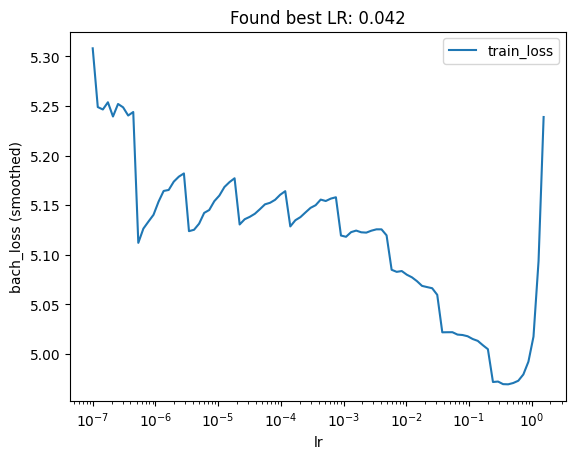

In [22]:
find_best_lr(deepsurv, train_set, plot=True)

In [23]:
%%time
deepsurv.optimizer.set_lr(0.01)
epochs = 512
batch_size = 256
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True
log = deepsurv.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=(x_val, y_val), val_batch_size=batch_size)


0:	[0s / 0s],		train_loss: 4.9192,	val_loss: 4.5570
1:	[0s / 0s],		train_loss: 4.8036,	val_loss: 4.5454
2:	[0s / 0s],		train_loss: 4.7841,	val_loss: 4.5334
3:	[0s / 0s],		train_loss: 4.7904,	val_loss: 4.5332
4:	[0s / 0s],		train_loss: 4.7759,	val_loss: 4.5319
5:	[0s / 0s],		train_loss: 4.7597,	val_loss: 4.5448
6:	[0s / 0s],		train_loss: 4.7707,	val_loss: 4.5328
7:	[0s / 0s],		train_loss: 4.7606,	val_loss: 4.5274
8:	[0s / 0s],		train_loss: 4.7486,	val_loss: 4.5404
9:	[0s / 0s],		train_loss: 4.7529,	val_loss: 4.5550
10:	[0s / 0s],		train_loss: 4.7518,	val_loss: 4.5468
11:	[0s / 0s],		train_loss: 4.7676,	val_loss: 4.5368
12:	[0s / 0s],		train_loss: 4.7564,	val_loss: 4.5316
13:	[0s / 0s],		train_loss: 4.7326,	val_loss: 4.5927
14:	[0s / 0s],		train_loss: 4.7448,	val_loss: 4.5470
15:	[0s / 0s],		train_loss: 4.7351,	val_loss: 4.5707
16:	[0s / 0s],		train_loss: 4.7596,	val_loss: 4.5459
17:	[0s / 0s],		train_loss: 4.7442,	val_loss: 4.5401
CPU times: user 566 ms, sys: 334 ms, total: 900 ms
Wall 

Text(0.5, 1.0, 'Partial-LogLik: -5.627')

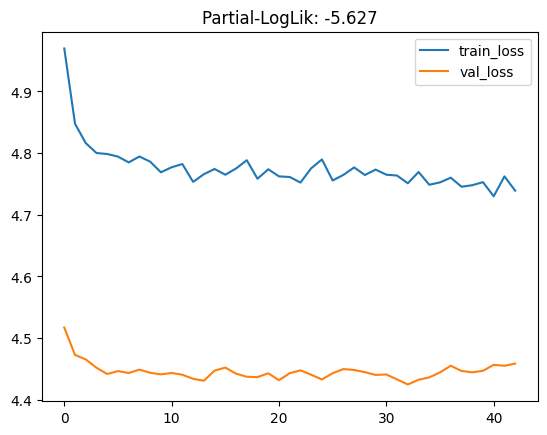

In [255]:
_ = log.plot()
plt.title(f"Partial-LogLik: {deepsurv.partial_log_likelihood(x_val, y_val).mean():.3f}")


### Prediction

In [256]:
_ = deepsurv.compute_baseline_hazards()

In [7]:
deepsurv

NameError: name 'deepsurv' is not defined

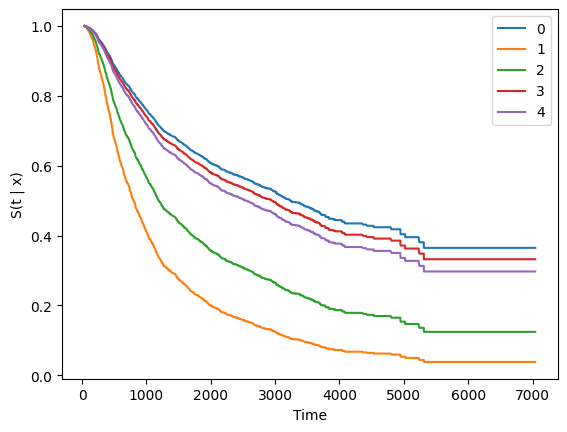

In [257]:
surv = deepsurv.predict_surv_df(x_test)
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')


### Evaluation

{'Ctd': 0.6070773716484309,
 'iBS': 0.2126540967157958,
 'iNBLL': 0.8732788959070757}

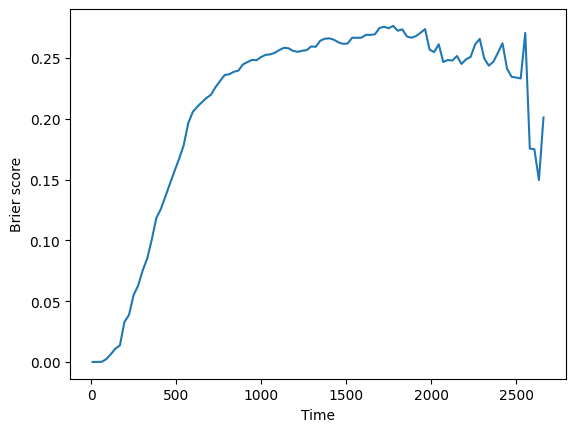

In [258]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
surv_metrics(ev, plot=True)

## DeepHit

In [259]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net_discrete = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [260]:
deephit = DeepHitSingle(net_discrete, tt.optim.Adam, alpha=0.2,
                      sigma=0.1, duration_index=labtrans.cuts)


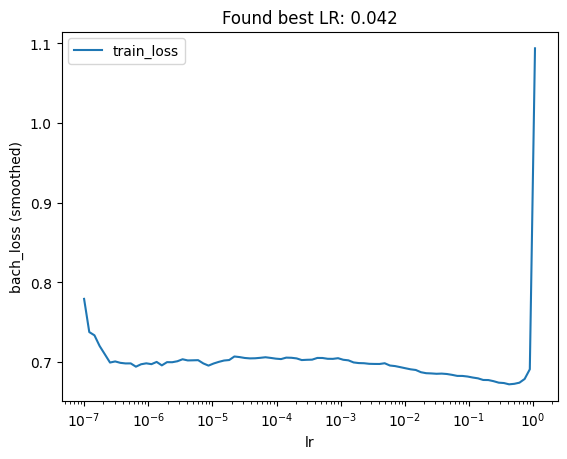

In [261]:
find_best_lr(deephit, train_set_discrete, plot=True)


In [262]:
%%time
deephit.optimizer.set_lr(0.01)
epochs = 512
batch_size = 256
callbacks = [tt.callbacks.EarlyStopping()]
log = deephit.fit(x_train, y_train_discrete, batch_size, epochs, callbacks, val_data=(x_val, y_val_discrete))


0:	[0s / 0s],		train_loss: 0.6601,	val_loss: 0.6931
1:	[0s / 0s],		train_loss: 0.6377,	val_loss: 0.6808
2:	[0s / 0s],		train_loss: 0.6208,	val_loss: 0.6677
3:	[0s / 0s],		train_loss: 0.6049,	val_loss: 0.6654
4:	[0s / 0s],		train_loss: 0.6012,	val_loss: 0.6619
5:	[0s / 0s],		train_loss: 0.5927,	val_loss: 0.6627
6:	[0s / 0s],		train_loss: 0.5859,	val_loss: 0.6560
7:	[0s / 0s],		train_loss: 0.5886,	val_loss: 0.6539
8:	[0s / 0s],		train_loss: 0.5788,	val_loss: 0.6662
9:	[0s / 0s],		train_loss: 0.5837,	val_loss: 0.6633
10:	[0s / 0s],		train_loss: 0.5819,	val_loss: 0.6608
11:	[0s / 0s],		train_loss: 0.5763,	val_loss: 0.6801
12:	[0s / 0s],		train_loss: 0.5796,	val_loss: 0.6817
13:	[0s / 0s],		train_loss: 0.5765,	val_loss: 0.6881
14:	[0s / 0s],		train_loss: 0.5778,	val_loss: 0.6837
15:	[0s / 0s],		train_loss: 0.5727,	val_loss: 0.6761
16:	[0s / 1s],		train_loss: 0.5777,	val_loss: 0.6756
17:	[0s / 1s],		train_loss: 0.5686,	val_loss: 0.6850
CPU times: user 1.2 s, sys: 488 ms, total: 1.68 s
Wall t

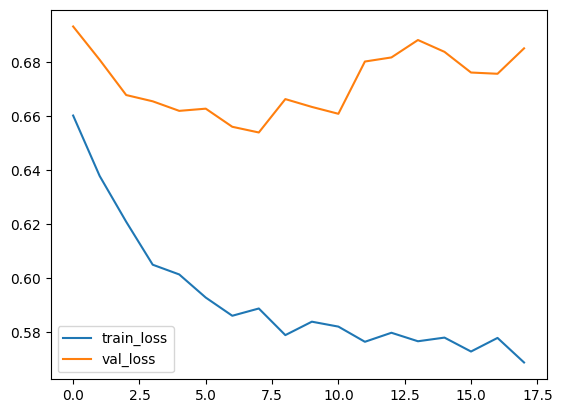

In [263]:
_ = log.plot()


### Prediction

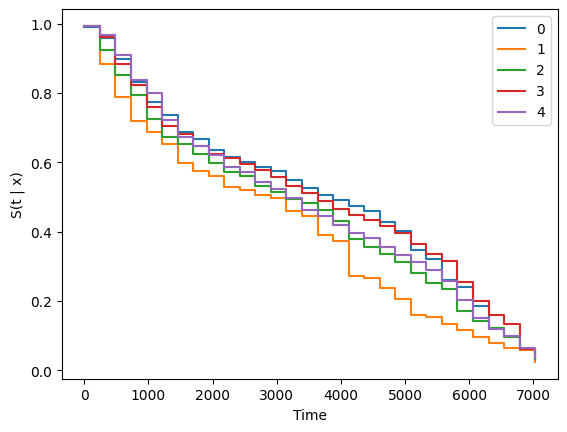

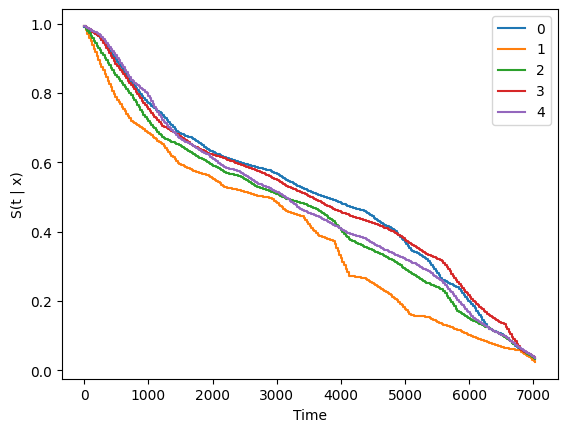

In [264]:
# Raw step survival function
deephit.predict_surv_df(x_test).iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

# Smoothed version
surv = deephit.interpolate(10).predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')


### Evaluation

{'Ctd': 0.6728387639773957,
 'iBS': 0.2002567889741852,
 'iNBLL': 0.5687472664027947}

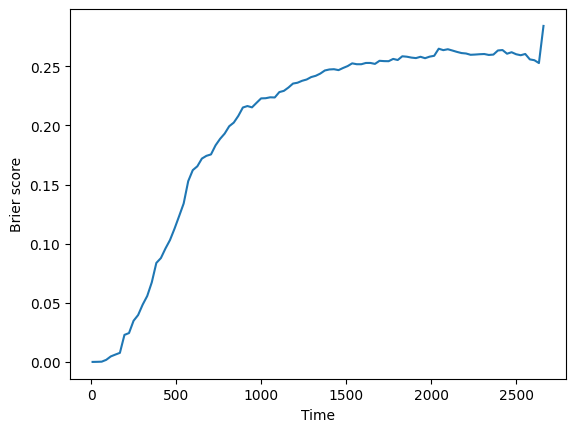

In [265]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
surv_metrics(ev, plot=True)


# Missing data

## Build dataset

In [266]:
t = 0.8 # approx ratio of NAs
mask_train = np.random.uniform(size=np.multiply(*x_train.shape)).reshape(x_train.shape)
x_train_masked = np.where(mask_train < t, np.nan, x_train)
print(sum(mask_train < t))

[1941 1911 1885 1890 1934 1893 1938 1914]


## Simple imputation

In [267]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='constant')
x_train_imputed = imp.fit_transform(x_train_masked)

0:	[0s / 0s],		train_loss: 0.6523,	val_loss: 0.6838
1:	[0s / 0s],		train_loss: 0.6430,	val_loss: 0.6983
2:	[0s / 0s],		train_loss: 0.6282,	val_loss: 0.6962
3:	[0s / 0s],		train_loss: 0.6249,	val_loss: 0.6842
4:	[0s / 0s],		train_loss: 0.6194,	val_loss: 0.6838
5:	[0s / 0s],		train_loss: 0.6156,	val_loss: 0.6815
6:	[0s / 0s],		train_loss: 0.6163,	val_loss: 0.6902
7:	[0s / 0s],		train_loss: 0.6126,	val_loss: 0.6964
8:	[0s / 0s],		train_loss: 0.6158,	val_loss: 0.6863
9:	[0s / 0s],		train_loss: 0.6127,	val_loss: 0.7108
10:	[0s / 0s],		train_loss: 0.6160,	val_loss: 0.6940
11:	[0s / 0s],		train_loss: 0.6127,	val_loss: 0.6940
12:	[0s / 0s],		train_loss: 0.6147,	val_loss: 0.6962
13:	[0s / 0s],		train_loss: 0.6067,	val_loss: 0.7080
14:	[0s / 0s],		train_loss: 0.6156,	val_loss: 0.6923
15:	[0s / 1s],		train_loss: 0.6151,	val_loss: 0.7043


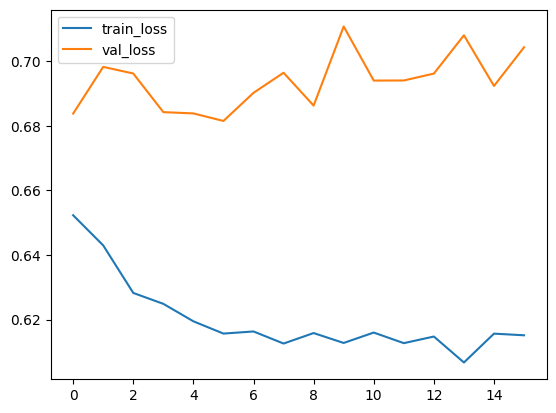

In [268]:
deephit = DeepHitSingle(net_discrete, tt.optim.Adam, alpha=0.2,
                        sigma=0.1, duration_index=labtrans.cuts)
deephit.optimizer.set_lr(0.01)
epochs = 512
batch_size = 256
callbacks = [tt.callbacks.EarlyStopping()]
log = deephit.fit(x_train_imputed, y_train_discrete, batch_size,
                  epochs, callbacks, val_data=(x_val, y_val_discrete))
_ = log.plot()


In [269]:
surv = deephit.interpolate(10).predict_surv_df(x_test)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
surv_metrics(ev, plot=False)


{'Ctd': 0.631064386196946,
 'iBS': 0.1970845029198271,
 'iNBLL': 0.5642474172228961}

## Multiple Imputation

In [270]:
from hyperimpute.plugins.imputers import Imputers

imputers = Imputers()

imp = imputers.get("missforest")

x_train_imputed = imp.fit_transform(x_train_masked.copy())


/Users/paulduf/Library/r-miniconda/envs/r-reticulate/lib/python3.8/site-packages/hyperimpute/plugins/imputers/_hyperimpute_internals.py:835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col][self.mask[col]] = est.predict(covs[self.mask[col]]).values.squeeze()
/Users/paulduf/Library/r-miniconda/envs/r-reticulate/lib/python3.8/site-packages/hyperimpute/plugins/imputers/_hyperimpute_internals.py:835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col][self.mask[col]] = est.predict(covs[self.mask[col]]).values.squeeze()
/Users/paulduf/Library/r-miniconda/envs/r-reticulate/lib/python3.8/site-packages/hyperimpute/plugins

In [271]:
x_train_imputed = x_train_imputed.values.astype('float32')


0:	[0s / 0s],		train_loss: 0.6439,	val_loss: 0.6796
1:	[0s / 0s],		train_loss: 0.6306,	val_loss: 0.6859
2:	[0s / 0s],		train_loss: 0.6281,	val_loss: 0.6718
3:	[0s / 0s],		train_loss: 0.6201,	val_loss: 0.6783
4:	[0s / 0s],		train_loss: 0.6259,	val_loss: 0.7087
5:	[0s / 0s],		train_loss: 0.6199,	val_loss: 0.6963
6:	[0s / 0s],		train_loss: 0.6221,	val_loss: 0.7968
7:	[0s / 0s],		train_loss: 0.6151,	val_loss: 0.8150
8:	[0s / 0s],		train_loss: 0.6096,	val_loss: 0.8653
9:	[0s / 0s],		train_loss: 0.6195,	val_loss: 0.8925
10:	[0s / 0s],		train_loss: 0.6169,	val_loss: 0.8370
11:	[0s / 0s],		train_loss: 0.6096,	val_loss: 0.8008
12:	[0s / 0s],		train_loss: 0.6124,	val_loss: 0.8783


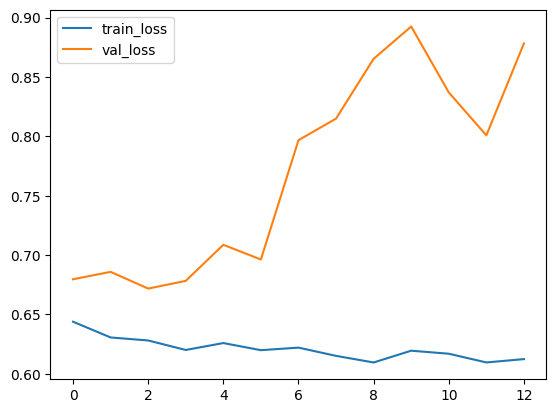

In [272]:
deephit = DeepHitSingle(net_discrete, tt.optim.Adam, alpha=0.2,
                        sigma=0.1, duration_index=labtrans.cuts)
deephit.optimizer.set_lr(0.01)
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = deephit.fit(x_train_imputed, y_train_discrete, batch_size,
                  epochs, callbacks, val_data=(x_val, y_val_discrete))
_ = log.plot()


In [273]:
surv = deephit.interpolate(10).predict_surv_df(x_test)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
surv_metrics(ev, plot=False)


{'Ctd': 0.6406231213177829,
 'iBS': 0.19946097438681828,
 'iNBLL': 0.568502201457338}

## NeuMiss

In [278]:
from neumiss import NeuMissBlock

In [279]:
neumiss_depth = 30
net_neumiss = torch.nn.Sequential(
    NeuMissBlock(in_features, neumiss_depth),
    torch.nn.Linear(in_features, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.BatchNorm1d(32),
    torch.nn.Dropout(0.1),
    
    torch.nn.Linear(32, out_features)
)

We set the `depth` parameter in the `NeuMissBlock` to `neumiss_depth = 10`.

0:	[0s / 0s],		train_loss: 0.6791,	val_loss: 0.6862
1:	[0s / 0s],		train_loss: 0.6511,	val_loss: 0.6978
2:	[0s / 0s],		train_loss: 0.6395,	val_loss: 0.7036
3:	[0s / 0s],		train_loss: 0.6303,	val_loss: 0.7433
4:	[0s / 0s],		train_loss: 0.6302,	val_loss: 0.7158
5:	[0s / 0s],		train_loss: 0.6235,	val_loss: 0.7817
6:	[0s / 0s],		train_loss: 0.6202,	val_loss: 0.7786
7:	[0s / 0s],		train_loss: 0.6185,	val_loss: 0.7419
8:	[0s / 0s],		train_loss: 0.6147,	val_loss: 0.7688
9:	[0s / 0s],		train_loss: 0.6184,	val_loss: 0.7487
10:	[0s / 1s],		train_loss: 0.6099,	val_loss: 0.8754


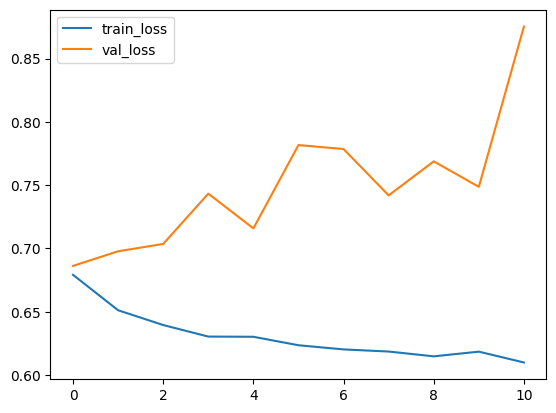

In [282]:
deephit = DeepHitSingle(net_neumiss, tt.optim.Adam, alpha=0.2,
                        sigma=0.1, duration_index=labtrans.cuts)
deephit.optimizer.set_lr(0.01)
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = deephit.fit(x_train_masked, y_train_discrete, batch_size,
                  epochs, callbacks, val_data=(x_val, y_val_discrete))
_ = log.plot()

In [283]:
surv = deephit.interpolate(10).predict_surv_df(x_test)
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
surv_metrics(ev, plot=False)


{'Ctd': 0.6659026692316942,
 'iBS': 0.21852947103019763,
 'iNBLL': 0.6139669868603777}